Installing necessary packages

In [2]:
%pip install numpy-stl -q

Note: you may need to restart the kernel to use updated packages.


In [3]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from astropy.io import fits
from scipy.ndimage import zoom
import stl
import jax.numpy as np

import dLux as dl
import dLux.utils as dlu
import dLuxToliman as dlT

In [4]:
def mesh_to_stl(X, Y, Z, N, file_name, unit_in='m', unit_out='mm', binary=True):
    """
    Inputs:
        X: 2D numpy array of values defining the x position of each pixel
        ie for a 1x1m sized mesh object with a 0.1m resolution we expect
        X = [[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]
             [0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]
                                ...
             [0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]
             [0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]]

        Y: 2D numpy array of values defining the y position of each pixel
        ie for a 1x1m sized mesh object with a 0.1m resolution we expect
        Y = [[[0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
             [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
                                ...
             [0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8]
             [0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9]]

        Z: 2D numpy array of values defining the z position (height) of each pixel
        using plt.imshow(Z) should yeild a 'surface map' type image

        N: The number of pixels in the array, ie X, Y, Z should all be NxN

        file_name: The path/name of the file name to save under

        unit_in: The input units of the X, Y, Z arrays. Default is meters.
        Can be 'm', 'mm', 'um', 'nm'

        unit_out: The output units of the stl file. ie for a 1x1m sized mesh object
        with units in mm we expect the X, Y output to range from 0 to 900. Default
        is milimeters. Can be 'm', 'mm', 'um', 'nm'

        binary: If True file will be output as binary (smaller), else ASCII (readable)
        
    Output:
        returns None, saves an stl file to disk
    
    -------------------------------------------------------------------
    Algorithm:
        Method: Decompose the traversal pattern into a series of simpler patters
        and combine them to get the final pattern.

        For a gridsize of N, we have N-1 squares in each row/column, giving a 
        total of (N-1)^2 sqaures and 2*(N-1)^2 triangles

        Each triangle is composed of three points and a so a square is made of 6 points

        Within the series of points there is a repeating pattern which can be 
        decomposed into thee different sequences and combines

        S1: [0,0,0], [1,1,1], [1,1,1], [2,2,2], [2,2,2], [3,3,3], ... 
        S2: [0,0,1], [0,0,1], [0,0,1], [0,0,1], [0,0,1], [0,0,1], ...
        S3: [N,N,N], [0,0,0], [N,N,N], [0,0,0], [N,N,N], [0,0,0], ...
        Combining these together gives us our repeating pattern, S = S1 + S2 + S3

        Note: These brackes are there to help define the repeating sequence and
        do not relate to the final grouping into triangles.

        The final sequence is then [0, 1, S, N-1] and represents a full row of triangles
        This final sequence is then repeated again with N added to each value, then
        again with 2*N added to each value and so on.
    """
    import numpy as np
    Z = np.array(Z)
        
    # Dictionary of indexes for scaling values
    dic = {
        'm': 0,
        'mm': 1,
        'um': 2,
        'nm': 3,
    }
    
    # Array of relevant scaling values
    # X axis is unit in, Y axis is unit out
    scale_arr = [[1, 1e-3, 1e-6, 1e-9],
                 [1e3, 1, 1e-3, 1e-6],
                 [1e6, 1e3, 1, 1e-3],
                 [1e9, 1e6, 1e3, 1]]
    
    points = np.array([X.flatten(), Y.flatten(), Z.flatten()]) * scale_arr[dic[unit_out]][dic[unit_in]]

    # Other Numer of trianges and squares
    squares_per_row = N-1 
    triangles_per_row = 2 * squares_per_row
    num_squares = squares_per_row**2
    num_triangles = 2*num_squares

    # Points per triangle and square
    points_per_triangle = 3
    points_per_square = 2 * points_per_triangle

    # Number of points per row
    points_per_row = squares_per_row * points_per_square

    # Size of the sequences
    sequence_size = points_per_row - 3
    full_sequence_size = sequence_size + 3

    # Create indexes used to create sequences
    i = np.linspace(0, sequence_size, num=sequence_size, endpoint=False)
    j = np.floor_divide(i, 3)

    # Sequence 1
    S1 = np.floor_divide(j+1, 2)

    # Sequence 2
    S2_mask = (i+1)%3 == 0
    S2 = np.ones(sequence_size)*S2_mask

    # Sequence 3
    S3_mask = j%2 == 0
    S3 = N*np.ones(sequence_size)*S3_mask

    # Add together
    S = S1 + S2 + S3

    # Non repeating start and end of array
    start = np.array([0, 1])
    end = np.array([squares_per_row])

    # Combine
    sequence = np.concatenate([start, S, end])
    base_sequence = np.tile(sequence, reps=squares_per_row)

    # Create meshgrid of integer N values for the different rows
    arr_x = np.linspace(0, full_sequence_size, num=full_sequence_size, endpoint=False)
    arr_y = np.linspace(0, squares_per_row, num=squares_per_row, endpoint=False)
    X, Y = np.meshgrid(arr_x, arr_y)
    incremental_sequence = N*Y.flatten() # Flatten here in order to combine

    # Combine sequences together to create final array
    full_sequence_flat = base_sequence + incremental_sequence
    full_sequence = full_sequence_flat.reshape([num_triangles,3])

    # Force integer values
    full_sequence = np.array(full_sequence, dtype=int)

    # Create the vertices and points arrays
    vertices = points.T
    faces = full_sequence

    # Create the mesh object
    grid_mesh = stl.mesh.Mesh(np.zeros(faces.shape[0], dtype=stl.mesh.Mesh.dtype))

    # input mesh vectors
    for i, f in enumerate(faces):
        for j in range(3):
            grid_mesh.vectors[i][j] = vertices[f[j],:]
            
    # Write the mesh to file
    if binary:
        grid_mesh.save('{}.stl'.format(file_name))
    else:
        grid_mesh.save('{}.stl'.format(file_name), mode=stl.Mode.ASCII)

In [5]:
def generate_sinusoids(aperture_diameter, npixels, period, amplitude, rotation=np.pi/4):
    """
    Calcaultes the sinusoidal grating and anti-grating patterns and their
    corresponding pixel positions.

    Parameters
    ----------
    aperture_diameter: float, meters
        Size of the aperture in metres
    npixels: int
        Number of pixels to calculate the grating on
    period: float, meters
        Period of the grating in metres
    amplitude: float, meters
        Amplitude of the grating in metres
    rotation: float, radians
        Rotation of the grating in radians
    
    Returns
    -------
    grating: np.ndarray
        2D array of the grating pattern
    anti_grating: np.ndarray
        2D array of the anti-grating pattern
    X: np.ndarray
        2D array of the X pixel positions
    Y: np.ndarray
        2D array of the Y pixel positions
    """
    # Cacluate coordinates
    X, Y = dlu.pixel_coords(npixels, aperture_diameter)
    
    # Rotate the coordinates
    R, PHI = dlu.cart2polar([X, Y])
    PHI += rotation
    X, Y = dlu.polar2cart([R, PHI])

    # Define the sine argument value to get the correct period
    B = 2*np.pi / period

    # Creating gratings
    grating =      (amplitude*np.cos(B*Y) +          amplitude*np.cos(B*X)        )/4
    anti_grating = (amplitude*np.cos(B*Y  + np.pi) + amplitude*np.cos(B*X + np.pi))/4
    
    # Note here we divide the output by 4: 
    # amplitude is a peak to trough value so we must halve the output once
    # To get orthogonal sine waves we sum two seperate 1D sine patterns
    # so the amplitude is doubled so we must halve again
    
    return grating, anti_grating, X, Y

def phase_to_depth(phase_array, wavelength, n1, n2):
    """
    Converts phase values to a depth for a specified wavelength through
    a substrate with refractive index n2, relative to the 'null' substrate with
    refractive index n1 (typically 1 for free space).

    Parameters
    ----------
    phase_array: np.ndarray
        2D array of phase values
    wavelength: float, meters
        Wavelength of the light in metres
    n1: float
        Refractive index of the substrate
    n2: float
        Refractive index of the top layer
    
    Returns
    -------
    depth_array: np.ndarray
        2D array of the depth values
    """
    return (phase_array * wavelength) / (2 * np.pi * (n2 - n1))

def scale_binary_mask(phase_mask, aperture_npix):
    """
    Scales the phase mask to the output size, enforcing 0-pi values

    Parameters
    ----------
    phase_mask: np.ndarray
        2D array of phase values
    aperture_npix: int
        Number of pixels in the output array
    
    Returns
    -------
    scaled_mask: np.ndarray
        2D array of the scaled phase values
    """
    ratio = phase_mask.shape[0] / aperture_npix
    scaled_mask = dlu.scale(phase_mask, aperture_npix, ratio)
    scaled_mask = scaled_mask.at[np.where(scaled_mask >= np.pi/2)].set(np.pi)
    scaled_mask = scaled_mask.at[np.where(scaled_mask <  np.pi/2)].set(0)
    return scaled_mask

def calculate_grating_period(max_reach, pixel_scale, det_npixels, wavelengths, aperture_diameter, aperture_npix):
    """
    Calculates the grating period for a given set of parameters

    Parameters
    ----------
    max_reach: float, ratio
        Maximum wavelength to diffract to 'max_reach' to the edge of the chip
    pixel_scale: float, radians
        Pixel scale of the detector
    det_npixels: int
        Number of pixels in the full detector
    wavelengths: np.ndarray, meters
        Array of wavelengths to diffract
    aperture_diameter: float, meters
        Diameter of the aperture
    aperture_npix: int
        Number of pixels in the aperture
    
    Returns
    -------
    period: float
        Period of the grating
    """
    diffraction_angle = max_reach*pixel_scale*np.sqrt(2)*(det_npixels/2)
    period = wavelengths.max()/np.sin(diffraction_angle)
    grating_sampling = period / (aperture_diameter/aperture_npix)
    print(f"Grating amplitude: {grating_sampling}")
    print(f"Nyquist Ratio: {grating_sampling/2}")
    return period

def impose_grating(mask, grating, anti_grating):
    """
    Impose the grating onto the mask

    Parameters
    ----------
    mask: np.ndarray
        2D array of the mask
    grating: np.ndarray
        2D array of the grating
    anti_grating: np.ndarray
        2D array of the anti grating

    Returns
    -------
    full_mask: np.ndarray
        2D array of the full mask
    """
    Gmask  = grating.at[np.where(mask == 0)].set(0.)
    AGmask = anti_grating.at[np.where(mask != 0)].set(0.)
    full_grating = Gmask + AGmask
    full_grating -= full_grating.min()
    full_mask = mask + full_grating
    return full_mask

def ApertureFactory(
    aperture_npix: int,
    aperture_diameter: float,
    secondary_diameter: float,
    oversample: int = 1):
    """
    Creates an Aperture using new dLux method

    Args:
        aperture_npix (int): Number of pixels in the aperture
        aperture_diameter (float): Diameter of the aperture in meters
        secondary_diameter (float): Diameter of the secondary in meters
        oversample (int, optional): Oversample factor. Defaults to 1.

    Returns:
        Aperture: Aperture object
    """

    # Generate a set of coordinates
    coords = dlu.pixel_coords(aperture_npix * oversample, aperture_diameter)

    # Create the aperture and mirror
    primary = dlu.circle(coords, aperture_diameter)
    secondary = dlu.circle(coords, secondary_diameter)

    aperture = dlu.combine([primary,secondary],oversample)

    return aperture



def make_grating_mask(
    phase_mask         : np.ndarray, 
    aperture_npix      : int, 
    aperture_diameter  : float, 
    secondary_diameter : float,
    spider_width       : float, 
    wavelengths        : np.ndarray, 
    amplitude          : float, 
    det_npixels        : int, 
    pixel_scale        : float, 
    max_reach          : float, 
    n1                 : float, 
    n2                 : float, 
    out                : float = np.nan, 
    apply_spiders      : bool = True,
    return_raw         : bool = False):
    """
    Makes a full grating mask for a given set of parameters

    Parameters
    ----------
    phase_mask: np.ndarray
        2D array of phase values
    aperture_npix: int
        Number of pixels in the output array
    aperture_diameter: float, meters
        Diameter of the aperture
    secondary_diameter: float, meters
        Diameter of the secondary
    spider_width: float, meters
        Width of the spiders
    wavelengths: np.ndarray, meters
        Array of wavelengths to diffract
    amplitude: float
        Amplitude of the grating
    det_npixels: int
        Number of pixels in the full detector
    pixel_scale: float, radians
        Pixel scale of the detector
    max_reach: float, ratio
        Maximum wavelength to diffract to 'max_reach' to the edge of the chip
    n1: float
        Refractive index of the substrate
    n2: float
        Refractive index of the top layer
    out: float = np.nan
        Value to use for the outside of the aperture
    apply_spiders: bool = True
        Apply spiders to the aperture
    return_raw: bool = False
        Return the mask, full mask and support
    
    Returns
    -------
    full_mask: np.ndarray
        2D array of the full mask
    """
    # Generate Aperture support
    # secondary_ratio = secondary_diameter/aperture_diameter
    # if apply_spiders:
    #     spider_ratio    = spider_width/aperture_diameter
    #     aperture = dl.ApertureFactory(aperture_npix, 
    #                                 secondary_ratio=secondary_ratio, 
    #                                 nstruts=3, 
    #                                 strut_rotation=-np.pi/2, 
    #                                 strut_ratio=spider_ratio)
    # else:
    aperture = ApertureFactory(aperture_npix, aperture_diameter, secondary_diameter)
    #support = aperture.transmission

    # Scale mask
    scaled_mask = scale_binary_mask(phase_mask, aperture_npix)

    # Calculate depth
    # mask = phase_to_opd(scaled_mask, wavelengths.mean())
    # mask = phase_to_depth(scaled_mask, wavelengths.mean() * 1e-9, n1, n2)
    mask = phase_to_depth(scaled_mask, wavelengths.mean(), n1, n2)

    # Calculate grating period
    period = calculate_grating_period(max_reach, pixel_scale, det_npixels, wavelengths, aperture_diameter, aperture_npix)
    print(f"Grating period: {period}m")

    # Create Grating
    grating, anti_grating, X, Y = generate_sinusoids(aperture_diameter, aperture_npix, period, amplitude)

    # plt.imshow(grating)
    # plt.colorbar()
    # plt.show()

    # plt.imshow(mask)
    # plt.colorbar()
    # plt.show()

    # Impose grating
    mask = impose_grating(mask, grating, anti_grating)

    # plt.imshow(mask)
    # plt.colorbar()
    # plt.show()

    # Apply Support
    # full_mask = mask.at[np.where(support == 0)].set(out)
    full_mask = mask

    if return_raw:
        return full_mask, mask, X, Y
    else:
        return full_mask

## Parameters

In [6]:
# Aperture parameters
# aperture_npix = 512
# aperture_npix = 2048
aperture_npix = 5000
aperture_diameter = 0.125 # 125mm
secondary_diameter = 0.032 # 32mm
# secondary_diameter *= 0.75
# secondary_diameter = 0.015
spider_width       = 0.002 # 2mm

print(aperture_diameter / aperture_npix)

# Observations Wavelegths
wavelengths = np.linspace(530e-9, 640e-9, 100)

# Subtrate parameters
n1 = 1 # Free space
n2 = 1.5424 # Approx Zerodur

# Mask
mask_path = 'diffractive_pupil.npy'
phase_mask = np.load(mask_path) * np.pi

# Grating Parameters
amplitude = 375e-9
#amplitude = 420e-9
# amplitude = 100e-9
# amplitude = 150e-9
# amplitude = 400e-9
# amplitude = 300e-9#
det_npixels = 2048 # DO NOT TOUCH
pixel_scale = dlu.arcsec2rad(0.375) # 0.375 arcsec per pixel
max_reach = 0.8 # Max wavelength to diffract to 80% to the edge of the chip

# Make the mask
# mask, raw_mask, support, X, Y = make_grating_mask(phase_mask, aperture_npix, aperture_diameter, secondary_diameter, spider_width, wavelengths, amplitude, det_npixels, pixel_scale, max_reach, n1, n2, return_raw=True)
mask, raw_mask, X, Y = make_grating_mask(phase_mask, aperture_npix, aperture_diameter, secondary_diameter, spider_width, wavelengths, amplitude, det_npixels, pixel_scale, max_reach, n1, n2, out = 0., apply_spiders=False, return_raw=True)

2.5e-05
Grating amplitude: 12.154280662536621
Nyquist Ratio: 6.0771403312683105
Grating period: 0.000303856999380514m


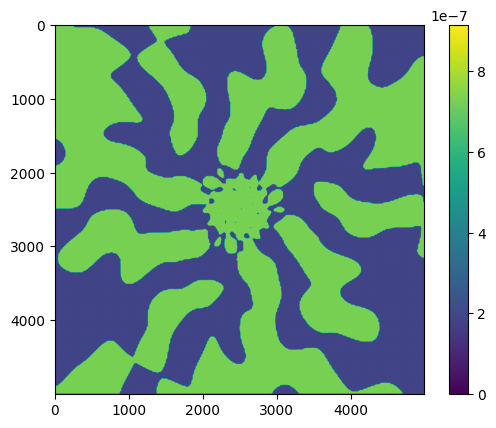

In [7]:
plt.imshow(mask)
plt.colorbar()

`mask` output here is a _depth_ for generating stl files. To get the equivilent opd, create a new depth_to_phase function and then pass the output to the `phase_to_opd(phase_mask, mean_wl)` and then use the code below

In [8]:
import dLux.utils as dlu

opd_mask = dlu.phase2opd(phase_mask, wavelengths.mean())

wf_npixels = aperture_npix
opd_mask = raw_mask*(n2-n1)
phase_mask = dlu.opd2phase(opd_mask, wavelengths.mean())
mask = dl.Optic(phase=phase_mask)
optics = dlT.TolimanOpticalSystem(wf_npixels=wf_npixels, mask=mask, psf_npixels=det_npixels, oversample=1)
source = dlT.AlphaCen(n_wavels=100, separation=8, position_angle=30)
#source = dlT.AlphaCen(n_wavels=10, separation=8, position_angle=30)


# # psf = optics.propagate(wavelengths)
# instrument = dlT.Toliman(optics, source)

# psf = instrument.model()


# c = psf.shape[0]//2
# s = 64

# plt.imshow(psf[c-s:c+s, c-s:c+s])
# # plt.imshow(psf)
# plt.colorbar()
# plt.show()

In [9]:
# plt.imshow(psf[c-s:c+s, c-s:c+s])
# plt.imshow(psf[200:400, 200:400])
# plt.colorbar()
# plt.show()

In [10]:
# plt.imshow(phase_mask)
# plt.colorbar()
# plt.show()
# print(np.mean(phase_mask))
# print(instrument)
# plt.imshow(instrument.pupil.phase)
# plt.colorbar()

In [11]:
# plt.imshow(instrument.pupil.phase[10:50, :40])
# plt.colorbar()

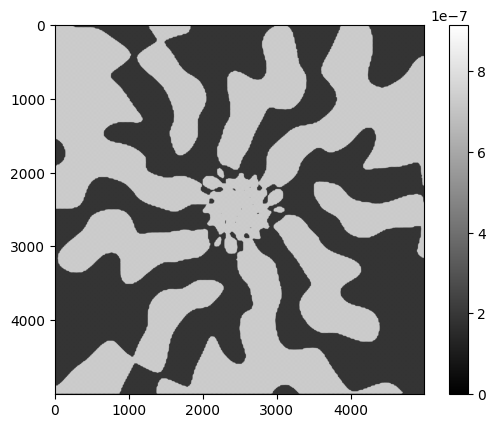

In [12]:
plt.imshow(raw_mask,cmap='gray')
plt.colorbar()
plt.show()

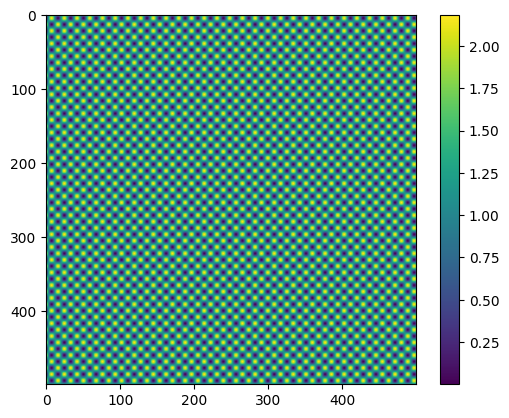

0.3476878
2.184587
7.78201e-06
2.1845949


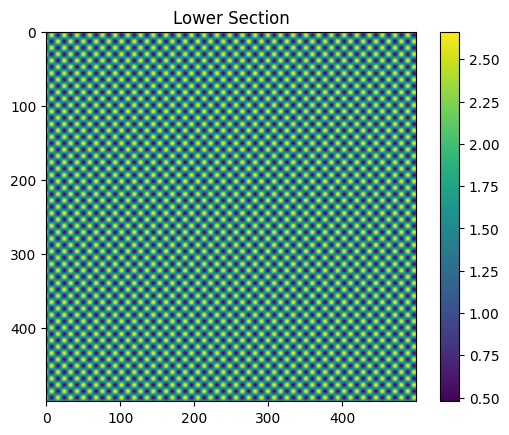

1.5707965


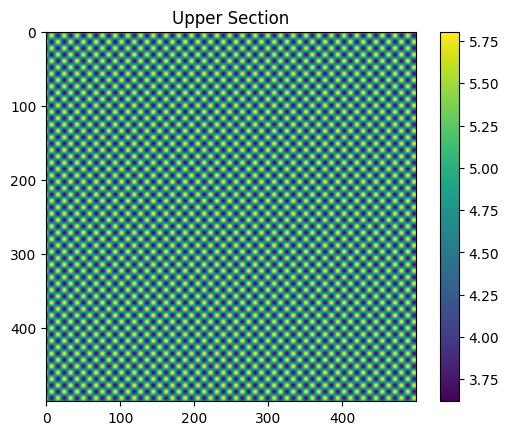

4.712391


In [13]:
#cutout = phase_mask[350:400,0:50]
cutout = phase_mask[3500:4000,0:500]
#cutout = phase_mask[3000:3200,200:400]
plt.imshow(cutout)
plt.colorbar()
plt.show()
print((cutout.max()- cutout.min())/(2*np.pi))
print(cutout.max()- cutout.min())
print(cutout.min())
print(cutout.max())


cutout_mean = np.mean(cutout)
elevation = (0.5*np.pi - cutout_mean)
phase_mask_elevated = phase_mask + elevation

#low_cutout_elevated = phase_mask_elevated[350:400,0:50]

low_cutout_elevated = phase_mask_elevated[3500:4000,0:500]
#cutout_elevated = phase_mask_elevated[3000:3200,200:400]
plt.imshow(low_cutout_elevated)
plt.title('Lower Section')
plt.colorbar()
plt.show()
print(np.mean(low_cutout_elevated))

#high_cutout_elevated = phase_mask_elevated[50:100,0:50]
high_cutout_elevated = phase_mask_elevated[500:1000,0:500]
#high_cutout_elevated = phase_mask_elevated[750:950,520:720]
plt.imshow(high_cutout_elevated)
plt.title('Upper Section')
plt.colorbar()
plt.show()
print(np.mean(high_cutout_elevated))


Calculate phase amplitude

In [26]:
p2p = (low_cutout_elevated.max()- low_cutout_elevated.min())/(2*np.pi)
print(p2p)

0.3476878


In [14]:
central = psf[c-s:c+s, c-s:c+s]
#plt.title(psf[c-s:c+s, c-s:c+s].sum())
plt.imshow(central)
plt.savefig('psf_center.png',dpi=500)
plt.colorbar()
plt.show()

NameError: name 'psf' is not defined

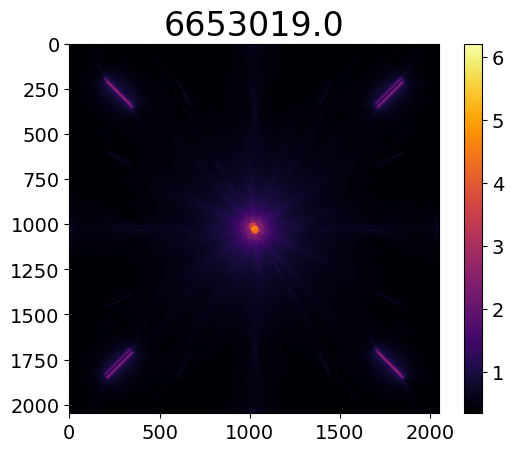

3.5e-07
0.7013471


In [ ]:
plt.title(psf.sum())
#plt.imshow(psf**0.1)
plt.imshow(psf**0.2, cmap='inferno')
plt.colorbar()
plt.savefig("full_psf.png")
plt.show()
print(amplitude)
print(central.sum()/psf.sum())

In [ ]:
psf[150:400, 150:400].sum()*100

Array(35958208., dtype=float32)

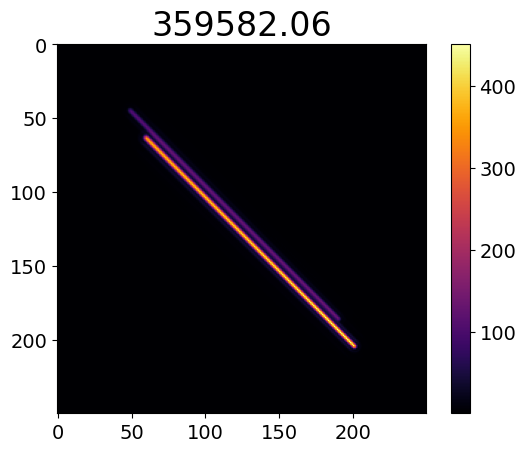

0.054047953


In [ ]:
side_lobe = psf[150:400, 150:400]

plt.title(side_lobe.sum())
plt.imshow(side_lobe, cmap='inferno')
plt.colorbar()
plt.savefig("sidelobe.png")
plt.show()
print(side_lobe.sum()/psf.sum())    

In [ ]:
optics

TolimanOpticalSystem(
  wf_npixels=5000,
  diameter=0.125,
  layers={
    'aperture':
    TransmissiveLayer(transmission=f32[5000,5000], normalise=True),
    'pupil':
    Optic(opd=None, phase=f32[5000,5000], transmission=None, normalise=False)
  },
  psf_npixels=2048,
  oversample=1,
  psf_pixel_scale=0.375
)

Cut out the circular parts

In [15]:
def create_circular_mask(h, w, center=None, radius=None):

    if center is None: # use the middle of the image
        center = (int(w/2), int(h/2))
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center <= radius
    return mask



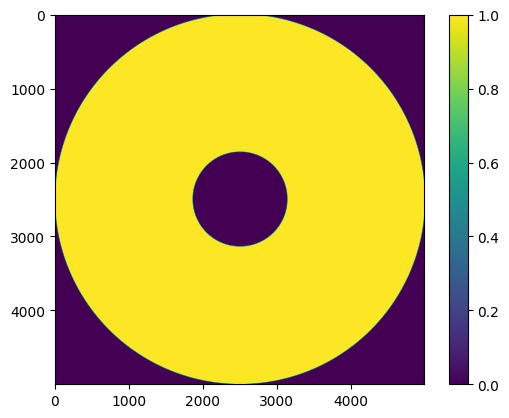

In [16]:
circular_mask_outer = create_circular_mask(aperture_npix,aperture_npix, radius=aperture_npix/2)
inner_r = (aperture_npix*(secondary_diameter/aperture_diameter))/2
circular_mask_inner = 1 - create_circular_mask(aperture_npix,aperture_npix, radius=inner_r)
circular_mask = circular_mask_outer & circular_mask_inner
plt.imshow(circular_mask)
plt.colorbar()
plt.show()

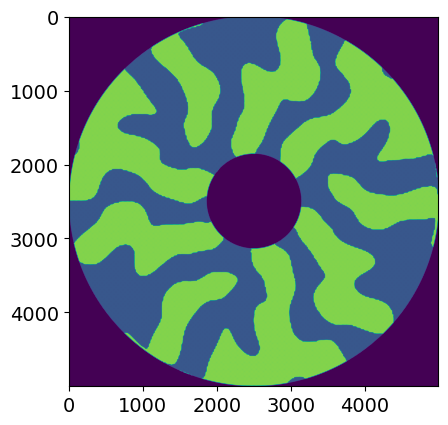

In [20]:
circular_elevated_phase_mask = (phase_mask+elevation) * circular_mask
#print(circular_elevated_phase_mask)

plt.rcParams.update({'font.size': 20})
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14) 

cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ['#000000','#02bde4'])

plt.imshow(circular_elevated_phase_mask,cmap="viridis")
# ticks = np.linspace(0,4096,3)
# ticklabels_x = np.linspace(-63,63,3)
# ticklabels_y = np.linspace(63,-63,3)
# ax.set_xticks(ticks)
# ax.set_xticklabels(ticklabels_x)
# ax.set_yticks(ticks)
# ax.set_yticklabels(ticklabels_y)
# plt.xlabel('x (pixels)')
# plt.ylabel('y (pixels)')
# plt.colorbar(label = 'Phase (rad)')
plt.imsave('full_diffractive_pupil.png', circular_elevated_phase_mask)
plt.show()

Convert the mask to a bitmap (adding to make mean pi)

In [21]:
np.save('new_diffractive_pupil.npy', circular_elevated_phase_mask)

TypeError: Image data of dtype object cannot be converted to float

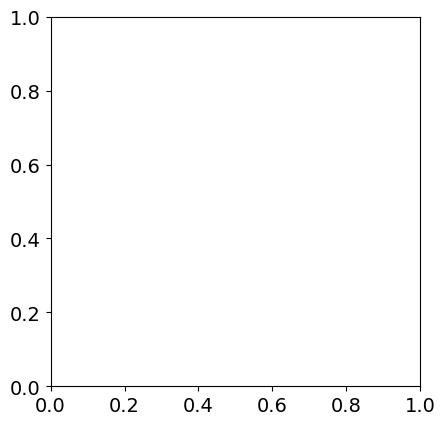

In [ ]:
plt.imshow(mask)
plt.colorbar()

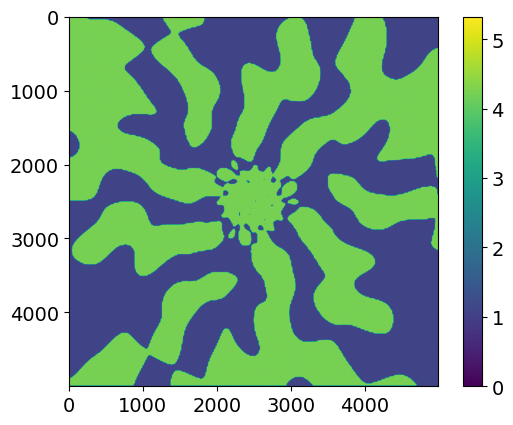

In [23]:
plt.imshow(phase_mask)
plt.colorbar()

In [22]:
period = calculate_grating_period(max_reach, pixel_scale, det_npixels, wavelengths, aperture_diameter, aperture_npix)
print(period)

Grating amplitude: 12.154280662536621
Nyquist Ratio: 6.0771403312683105
0.000303857


TypeError: Image data of dtype object cannot be converted to float

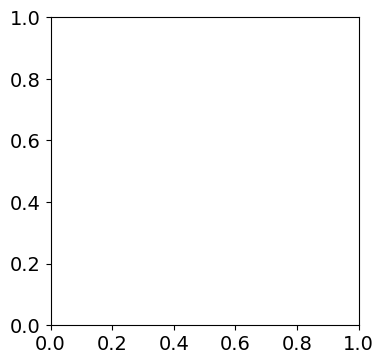

In [ ]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(mask)
# plt.imshow(raw_mask)
plt.colorbar()

plt.subplot(1, 2, 2)
s0 = 1500
s1 = s0 + 100
plt.imshow(mask[s0:s1, s0:s1])
# plt.imshow(raw_mask[s0:s1, s0:s1])
plt.colorbar()
plt.show()

In [ ]:
# !pip install dLuxToliman -q

In [ ]:
mesh_to_stl(X, Y, mask, aperture_npix, 'files/test_file_m', unit_in='m', unit_out='m', binary=True)
mesh_to_stl(X, Y, mask, aperture_npix, 'files/test_file_mm', unit_in='m', unit_out='mm', binary=True)
mesh_to_stl(X, Y, mask, aperture_npix, 'files/test_file_um', unit_in='m', unit_out='um', binary=True)
mesh_to_stl(X, Y, mask, aperture_npix, 'files/test_file_nm', unit_in='m', unit_out='nm', binary=True)

In [ ]:
large_mask = mask * 1e3
mesh_to_stl(X, Y, large_mask, aperture_npix, 'files/test_file_1e3_m', unit_in='m', unit_out='m', binary=True)
mesh_to_stl(X, Y, large_mask, aperture_npix, 'files/test_file_1e3_mm', unit_in='m', unit_out='mm', binary=True)
mesh_to_stl(X, Y, large_mask, aperture_npix, 'files/test_file_1e3_um', unit_in='m', unit_out='um', binary=True)
mesh_to_stl(X, Y, large_mask, aperture_npix, 'files/test_file_1e3_nm', unit_in='m', unit_out='nm', binary=True)

In [ ]:
large_mask = mask * 1e6
mesh_to_stl(X, Y, large_mask, aperture_npix, 'files/test_file_1e6_m', unit_in='m', unit_out='m', binary=True)
mesh_to_stl(X, Y, large_mask, aperture_npix, 'files/test_file_1e6_mm', unit_in='m', unit_out='mm', binary=True)
mesh_to_stl(X, Y, large_mask, aperture_npix, 'files/test_file_1e6_um', unit_in='m', unit_out='um', binary=True)
mesh_to_stl(X, Y, large_mask, aperture_npix, 'files/test_file_1e6_nm', unit_in='m', unit_out='nm', binary=True)

In [ ]:
import dLux
class ApplyMask(dLux.optics.OpticalLayer):
    depth : np.ndarray
    n : np.ndarray

    def __init__(self, depth, n):
        super().__init__(name='ApplyMask')
        self.depth = np.asarray(depth, float)
        self.n = np.asarray(n, float)
    
    def __call__(self, wavefront):
        opd = self.depth * self.n
        return wavefront.add_opd(opd)

In [ ]:
# Primary and secondary parameters
wf_npix = aperture_npix
layers = [dl.CreateWavefront(wf_npix, aperture_diameter, 'Angular')]

# Aperture parameters
secondary_ratio = secondary_diameter/aperture_diameter
spider_ratio    = spider_width/aperture_diameter
aperture = dl.ApertureFactory(wf_npix, 
                             secondary_ratio=secondary_ratio, 
                             nstruts=3, 
                             strut_rotation=-np.pi/2, 
                             strut_ratio=spider_ratio)
layers.append(aperture)
layers.append(dl.NormaliseWavefront())

# # Mask
# layers.append(dl.AddOPD(mask))

# # CLIMB mask
# seed = 0
# mask_basis = np.load("optimisation_params/basis.npy")
# mask_coeffs = jr.normal(jr.PRNGKey(seed), (mask_basis.shape[0],))
# mask = dl.ApplyBasisCLIMB(mask_basis, spec_wavelengths.mean(), mask_coeffs)
# layers.append(mask)
layers.append(ApplyMask(mask, n2))

# # Aberrations layer
# zernike_basis = 1e-9*dl.SimpleAperture(wf_npix, zernikes=np.arange(4, 11)).basis
# aberrations = dl.ApplyBasisOPD(zernike_basis)
# layers.append(aberrations)

# Propagator
# det_npix = 200
oversample = 1
# pixelscale = arcsec_to_rad(0.375)
propagator = dl.AngularMFT(oversample*det_npixels, pixel_scale/oversample, 
                           pixel_shift=True)
layers.append(propagator)

# Optics and telescope
optics = dl.Optics(layers)

In [ ]:
optics.summarise()

In [ ]:
full_wavels = np.linspace(545e-9, 645e-9, 100)

source = dl.PointSource(wavelengths=full_wavels)
psf = optics.model(source=source)

In [ ]:
psf.sum()

In [ ]:
plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.title("Full Chip")
plt.imshow(psf)
plt.colorbar()

plt.subplot(1, 2, 2)
plt.title("Full Chip sqrt scale")
plt.imshow(psf**0.5)
plt.colorbar()
plt.savefig("full_chip")

In [ ]:
# Central region
c = psf.shape[0]//2
s = 100

cen = psf[c-s:c+s, c-s:c+s]

# Corners
s0 = 170
s1 = s0 + 200

corn1 = psf[s0:s1, s0:s1] # Top left
corn2 = psf[s0:s1, -s1:-s0] # Top right
corn3 = psf[-s1:-s0, s0:s1] # Bottom left
corn4 = psf[-s1:-s0, -s1:-s0] # Bottom right
corns = [corn1, corn2, corn3, corn4]

s = 1e3
plt.figure(figsize=(15, 15))
plt.subplot(3, 3, 5)
plt.title(f"{cen.sum()*100:.2f}% total flux")
plt.imshow(cen*s)
plt.colorbar()

indexes = [1, 3, 7, 9]
for i in range(len(corns)):
    plt.subplot(3, 3, indexes[i])
    plt.title(f"{corns[i].sum()*100:.2f}% total flux")
    plt.imshow(corns[i]*s)
    plt.colorbar()

plt.savefig("transmissive_mask.png")

In [ ]:
print(np.array(corns).sum())

In [ ]:
psf.sum()

In [ ]:
import pathlib

In [ ]:
pathlib.Path

In [ ]:
import os

print(os.getcwd())
p = pathlib.Path("test")

In [ ]:
isinstance(p, pathlib.Path)

In [ ]:
str(p)

In [ ]:
import zodiax as zdx
from jax import numpy as np, scipy as scp


# A simple class to model 1d normals
class Normal(zdx.Base):
    mean      : np.ndarray
    scale     : np.ndarray
    amplitude : np.ndarray

    def __init__(self, mean, scale, amplitude):
        self.mean      = np.asarray(mean,      dtype=float)
        self.scale     = np.asarray(scale,     dtype=float)
        self.amplitude = np.asarray(amplitude, dtype=float)
    
    def model(self, width=10):
        xs = np.linspace(-width, width, 128)
        return self.amplitude * scp.stats.norm.pdf(xs, self.mean, self.scale)


# A class to store and model a set of normals
class NormalSet(zdx.Base):
    normals : dict
    width   : np.ndarray

    def __init__(self, means, scales, amplitude, names, width=10):
        normals = {}
        for i in range(len(names)):
            normals[names[i]] = Normal(means[i], scales[i], amplitude[i])
        self.normals = normals
        self.width = np.asarray(width, dtype=float)
    
    def __getattr__(self, key):
        if key in self.normals.keys():
            return self.normals[key]
        else:
            raise AttributeError(f"{key} not in {self.normals.keys()}")
    
    def model(self):
        return np.array([normal.model(self.width) 
            for normal in self.normals.values()]).sum(0)

sources = NormalSet([-1., 2.], [1., 2.], [2., 4.], ['alpha', 'beta'])

In [ ]:
zdx.experimental.serialise(p, sources)